# Iris Dataset - Exploratory Data Analysis

The iris flower dataset, also referred as Fisher's Iris dataset (after Ronald Fisher), was firstly introduced in 1936 and has since been incredibly popular due to its simple domain and its somehow magical ability to produce good statistical results.

The dataset consists of 150 samples from 3 species of Iris flower, namely Iris versicolor, Iris virginica, and Iris setosa. The classes are evenly distributed in the dataset, meaning that the 3 classes have 50 samples each. Each sample contains the width and length of both sepals and petals. 

## Loading the dataset

The dataset is provided by the University of California Irvine Machine Learning Repository. The url for downloading the file is:

https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

The data file is formatted as a csv file. To load this file into the memory you can use the code below.

The loaded and parsed dataset looks like this:

    [{'sepal_length': 5.1,
      'sepal_width': 3.5,
      'petal_length': 1.4,
      'petal_width': 0.2,
      'iris_class': 'Iris-setosa'},
     {'sepal_length': 4.9,
      'sepal_width': 3.0,
      'petal_length': 1.4,
      'petal_width': 0.2,
      'iris_class': 'Iris-setosa'},
     {'sepal_length': 4.7,
      'sepal_width': 3.2,
      'petal_length': 1.3,
      'petal_width': 0.2,
      'iris_class': 'Iris-setosa'},
      ...],

In [1]:
import requests

url = (
    'https://archive.ics.uci.edu/'
    'ml/machine-learning-databases'
    '/iris/iris.data'
)

response = requests.get(url)
response_decoded = response.content.decode('utf-8')

# Split the response line by line, using a comma delimiter.
# Also handles the empty line in the end of the file.
raw_dataset = [
    row.split(',') 
    for row in response_decoded.split('\n')
    if row
]
dataset = [{
    'sepal_length': float(row[0]),
    'sepal_width': float(row[1]),
    'petal_length': float(row[2]),
    'petal_width': float(row[3]),
    'iris_class': row[4],
} for row in raw_dataset]

## Using pandas DataFrame class

In order to facilitate the extraction of some basic statistics, we will instantiate a DataFrame object using the dataset we parsed in the previous step: 

In [2]:
import pandas as pd

df = pd.DataFrame(data=dataset)

## Pair plot view

A pair plot allows us to display the relationships between variables in a dataset in a pairwise view. It is particularly useful for quickly understanding relevant variables and for determining types of regression analysis to use. 

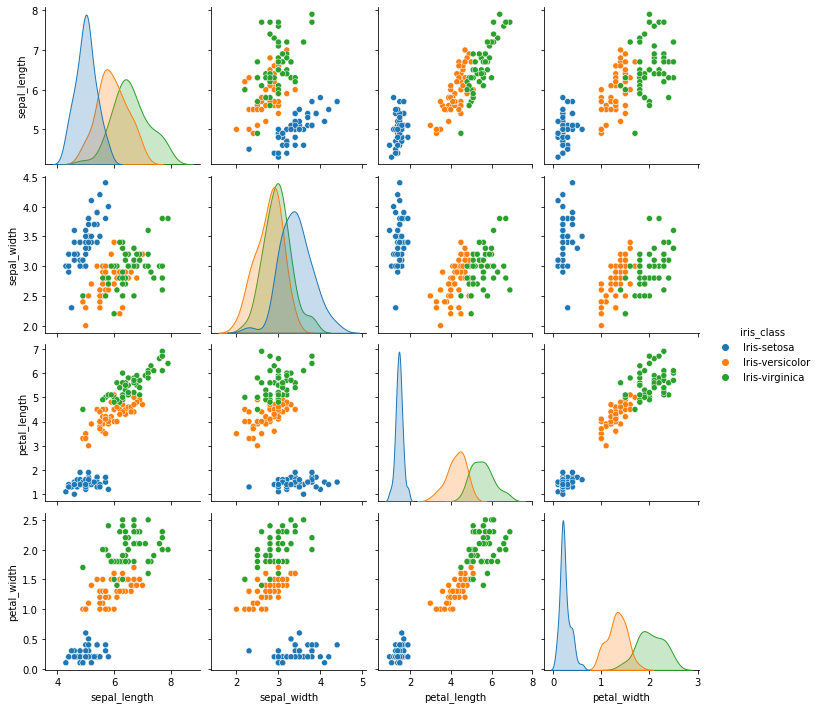

In [3]:
import seaborn as sns

sns.pairplot(df, hue='iris_class')

 Note that the main diagonal plots an univariate distribution that shows the marginal distribution of the data in each column. E.g., take the graph from the first element in the main diagonal. This graph is the univariate distribution of sepal length. From this, we can estimate that if an iris species has a sepal length of 5cm, it is way more likely to be a Setosa rather than a Veriscolor or Virginica.

There is a few things to notice from the pair plot view above:

1. In all the scatter plots, the Iris Setosa species belongs to a cluster of its own. In other words, we don't see entries from Versicolor and Virginica (green and orange) overlapping with Setosa entries (blue) in any of the scatter plots above.
2. Although the Veriscolor and Virginica entries usually overlap, this overlapping is due to a few outliers, therefore finding the proper clusters that minimise prediction errors won't be an impossible task.
3. Either petal_width or petal_length can be used to completely identify Iris Setosa entries from this database. Although this generalisation may not hold for a larger dataset, it is good to keep in mind that Setosas have the smallest petals in both length and width.
4. Virginica is the only class to present petals with widths of more than 2 centimetres. It is also the one to present petals with length of more than 6cm.
5. The combination of the variables sepal_length and sepal_width does not seem to be a good choice for distinguishing Virginicas from Versicolors. 

One interesting scatter plot that would show us relatively clean clusters is the petal_width vs petal_length one: 

<AxesSubplot:xlabel='petal_width', ylabel='petal_length'>

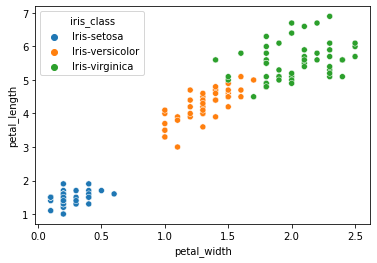

In [4]:
sns.scatterplot(data=df, x='petal_width', y='petal_length', hue='iris_class')

 We can see how the three clusters in the sketch above are relatively apart from each other (even though there is some small error between Versicolor and Virginica). Other scatter plots that also indicate good separation of classes are: sepal_width vs petal_width and sepal_width vs petal_length.

For a quick analysis the sketch above would be sufficient as the result of a clustering algorithm would be pretty obvious, but in order to confirm the sketch above is valid let's plot the result of the K-means algorithm applied to the same data. 

Text(0, 0.5, 'petal_length')

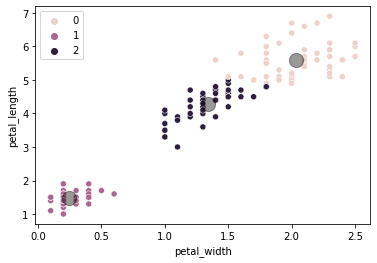

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = df[['petal_width', 'petal_length']]
km = KMeans(n_clusters=3)
y_kmeans = km.fit_predict(X)

sns.scatterplot(
    data=df,
    x="petal_width", y="petal_length",
    hue=y_kmeans
)
centers = km.cluster_centers_
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c='black',
    s=200, alpha=0.4
)
plt.xlabel("petal_width")
plt.ylabel("petal_length")

We can infer that 0=Virginica, 1=Setosa, 2=Versicolor. As expected, we can see that there are prediction errors between Versicolor and Virginica when comparing with the previous plot, but in general the clusters have a satisfiable accuracy considering we are only taking into account two dimensions of the data. 

## Can we find new taxonomies?

Some views from the pair plot above suggest that there is a small amount of differences between the Versicolor and the Virginica species. Besides that, when analysing the sepal width against the sepal length, there seems to be no clear distinction between both species. This might mean that there is the opportunity to analyse whether a missing taxonomy could be included to better split the differences between those two species, or if they both species should just be merged together into one.

Even if the analysis proves untrue for both hypothesis, the exercise itself is still a valid effort.

The algorithm that will be used to help us with this task is called Agglomerative Hierarchical Clustering. This type of clustering technique does not involve assuming the number of clusters a priori, which gives us the flexibility of finding new taxonomies without having to assume or infer opinions about the dataset.

It is important to point out a few limitations of this clustering technique: A) highly sensitive to noise and outliers. B) Difficulty handling non-globular shapes. C) Difficulty handling clusters of different sizes.

To highlight the fragility pointed out by A) let's run the algorithm for the sepal width and length dimensions using the Euclidean affinity along with the Single linkage: 

<AxesSubplot:xlabel='sepal_width', ylabel='sepal_length'>

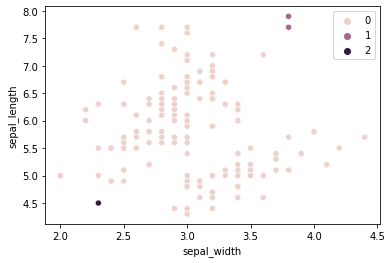

In [6]:
from sklearn.cluster import AgglomerativeClustering 

X = df[['sepal_width', 'sepal_length']]

ac = AgglomerativeClustering(
    n_clusters=3,
    affinity='euclidean',
    linkage='single'
)
y_ac = ac.fit_predict(X)

sns.scatterplot(
    data=df,
    x="sepal_width", y="sepal_length",
    hue=y_ac
)

The result is not nearly satisfactory. 147 samples were put into the same class, which is obviously untrue. The combination of dimensions chosen along with using the Single linkage criterion for calculating distances is not the appropriate configuration to solve this clustering problem. A better linkage criterion to use for this problem would be the ward criterion: 

<AxesSubplot:xlabel='sepal_width', ylabel='sepal_length'>

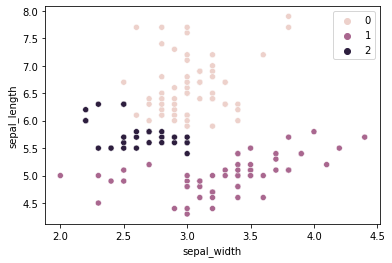

In [7]:
from sklearn.cluster import AgglomerativeClustering 

X = df[['sepal_width', 'sepal_length']]

ac = AgglomerativeClustering(
    n_clusters=3,
    affinity='euclidean',
    linkage='ward'
)
y_ac = ac.fit_predict(X)

sns.scatterplot(
    data=df,
    x="sepal_width", y="sepal_length",
    hue=y_ac
)

The result is still unsatisfactory, but there is less error when compared to the original classification.

Now let's go back to the petal width/length dimensions and see how the agglomerative clustering compares to the K-means clustering applied earlier. 

<AxesSubplot:xlabel='petal_width', ylabel='petal_length'>

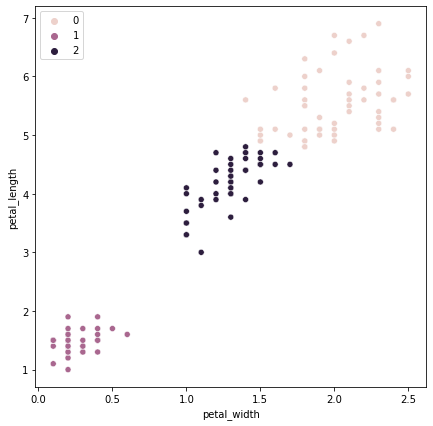

In [14]:
from sklearn.cluster import AgglomerativeClustering 

X = df[['petal_width', 'petal_length']]

ac = AgglomerativeClustering(
    n_clusters=3,
    affinity='euclidean',
    linkage='ward'
)
y_ac = ac.fit_predict(X)

sns.scatterplot(
    data=df,
    x="petal_width", y="petal_length",
    hue=y_ac
)

The result is very similar to the K-means clustering algorithm, there are only two samples that got a different classification.

One interesting point to raise is that adding new clusters means creating subdivisions between Versicolor and Virginica, but Setosa continues to be isolated in its own cluster. Using 5 clusters: 

<AxesSubplot:xlabel='petal_width', ylabel='petal_length'>

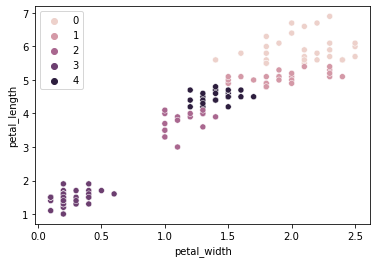

In [8]:
from sklearn.cluster import AgglomerativeClustering 

X = df[['petal_width', 'petal_length']]

ac = AgglomerativeClustering(
    n_clusters=5,
    affinity='euclidean',
    linkage='ward'
)
y_ac = ac.fit_predict(X)

sns.scatterplot(
    data=df,
    x="petal_width", y="petal_length",
    hue=y_ac
)

Looking blindly at the data, we could make the mistake of saying that there might be room for more taxonomies to be explored between Versicolor and Virginica based on these two dimensions alone, but in reality this assumption is too big of a jump as it is not considering other dimensions (features) that might be more important for classifying a specie. A more reasonable assertion to say is that Iris Setosa is its own specie as its cluster remains unchanged even when trying to create more clusters for the dataset, whereas the distinction between Versicolor and Virginica remains ambiguous if only looking unilaterally through this set of dimensions. 

## Dendrogram

We have mentioned above that one of the strengths of the hierarchical algorithm we used is that it does not need to assume an initial number of clusters. We haven't used this advantage yet.

Hierarchical clustering algorithms create dendrograms in the process of fitting the data. These dendrograms are used to define what is the most optimal amount of clusters to use. This will allows us to understand what mathematics think about our taxonomy.

The dendrogram can be hard to read when the linkage matrix is large. This is the case as we'll be creating the linkage matrix from all 150 samples. To condense the dendrogram, we can call the scipy function dendogram() with truncate_mode set to 'level' along with the 'p' number of levels we want to display. 

Text(0.5, 0, 'Number of points in node (or index of point if no parenthesis).')

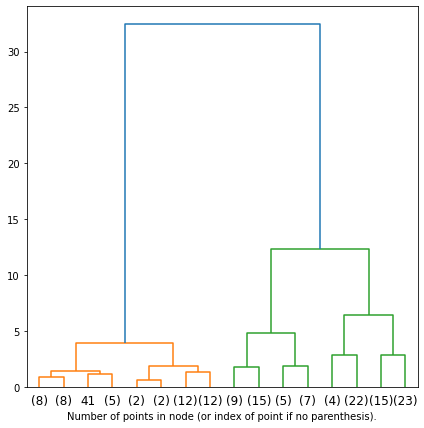

In [9]:
# code based and adapted from sklearn:
# "Plot Hierarchical Clustering Dendrogram"

import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# makes plot appear larger.
plt.rcParams['figure.figsize'] = [7, 7]

def create_linkage_matrix(model):
    non_leaf_node_children = model.children_
    
    # counts the number of samples under each node (see plot)
    counts = np.zeros(non_leaf_node_children.shape[0])
    n_samples = 150
    for i, children in enumerate(non_leaf_node_children):
        count = 0
        for child in children:
            if child < n_samples:
                # it is a leaf node
                count += 1
            else:
                count += counts[child - n_samples]
        counts[i] = count
    
    return np.column_stack([
        non_leaf_node_children,
        model.distances_,
        counts
    ]).astype(float)
    
X = df[[
    'petal_width', 'petal_length',
    'sepal_width', 'sepal_length'
]].to_numpy()

model = AgglomerativeClustering(
    compute_full_tree=True,
    distance_threshold=0,
    n_clusters=None
)
model = model.fit(X)

linkage_matrix = create_linkage_matrix(model)

dendrogram(linkage_matrix, truncate_mode='level', p=3)
plt.xlabel(
    'Number of points in node '
    '(or index of point if no parenthesis).'
)

The higher the distance between nodes in the dendrogram, the larger their dissimilarities. In this particular case, there seems to be no ideal choice between picking 2 or 3 clusters. There is a big dissimilarity between the cluster made of Setosas (orange) versus the cluster made of the combination of both Virginicas and Versicolors (green), which agrees with our previous analysis. This means that naturally, the hierarchical clustering technique would interpret the dataset as belonging to two clusters only.

There is one problem with this choice of clusters. Dendrograms need to be interpreted, and much of this interpretation comes with intuition. Although the maximum distance points to 2 clusters, the distance between Virginicas and Versicolors is still relatively significant to be ignored. 3 clusters might actually be the best pick in terms of dissimilarity distances for this dataset if we are to consider the dissimilarities between Virginicas and Versicolors significant enough for being included in our taxonomy. If so, 3 would be the ideal number of clusters. 

## Other general information for reference (mean, std, min, and max)

The code below shows how this extraction of information happens. A more readable format to read this information is provided next. 

In [10]:
# Overall mean
print('Overall Mean:')
print(df.mean())

# setosa mean
setosa_df = df.where(df['iris_class'] == 'Iris-setosa')
print('\nSetosa mean:')
print(setosa_df.mean())

# versicolor mean
versicolor_df = df.where(df['iris_class'] == 'Iris-versicolor')
print('\nVersicolor mean:')
print(versicolor_df.mean())

# setosa mean
virginica_df = df.where(df['iris_class'] == 'Iris-virginica')
print('\nVirginica mean:')
print(virginica_df.mean())

Overall Mean:
sepal_length    5.843333
sepal_width     3.054000
petal_length    3.758667
petal_width     1.198667
dtype: float64

Setosa mean:
sepal_length    5.006
sepal_width     3.418
petal_length    1.464
petal_width     0.244
dtype: float64

Versicolor mean:
sepal_length    5.936
sepal_width     2.770
petal_length    4.260
petal_width     1.326
dtype: float64

Virginica mean:
sepal_length    6.588
sepal_width     2.974
petal_length    5.552
petal_width     2.026
dtype: float64


In [11]:
# Overal std
print('\nOverall Standard Deviation:')
print(df.std())

# setosa std
print('\nSetosa Standard Deviation:')
print(setosa_df.std())

# versicolor std
print('\nVersicolor Standard Deviation:')
print(versicolor_df.std())

# setosa std
print('\nVirginica Standard Deviation:')
print(virginica_df.std())


Overall Standard Deviation:
sepal_length    0.828066
sepal_width     0.433594
petal_length    1.764420
petal_width     0.763161
dtype: float64

Setosa Standard Deviation:
sepal_length    0.352490
sepal_width     0.381024
petal_length    0.173511
petal_width     0.107210
dtype: float64

Versicolor Standard Deviation:
sepal_length    0.516171
sepal_width     0.313798
petal_length    0.469911
petal_width     0.197753
dtype: float64

Virginica Standard Deviation:
sepal_length    0.635880
sepal_width     0.322497
petal_length    0.551895
petal_width     0.274650
dtype: float64


In [12]:
# Overal min
print('\nOverall Minimum:')
print(df.min())

# setosa min
print('\nSetosa Minimum:')
print(setosa_df.min())

# versicolor min
print('\nVersicolor Minimum:')
print(versicolor_df.min())

# setosa min
print('\nVirginica Minimum:')
print(virginica_df.min())


Overall Minimum:
sepal_length            4.3
sepal_width             2.0
petal_length            1.0
petal_width             0.1
iris_class      Iris-setosa
dtype: object

Setosa Minimum:
sepal_length    4.3
sepal_width     2.3
petal_length    1.0
petal_width     0.1
dtype: float64

Versicolor Minimum:
sepal_length    4.9
sepal_width     2.0
petal_length    3.0
petal_width     1.0
dtype: float64

Virginica Minimum:
sepal_length    4.9
sepal_width     2.2
petal_length    4.5
petal_width     1.4
dtype: float64


In [13]:
# Overal max
print('\nOverall Maximum:')
print(df.max())

# setosa max
print('\nSetosa Maximum:')
print(setosa_df.max())

# versicolor max
print('\nVersicolor Maximum:')
print(versicolor_df.max())

# setosa max
print('\nVirginica Maximum:')
print(virginica_df.max())


Overall Maximum:
sepal_length               7.9
sepal_width                4.4
petal_length               6.9
petal_width                2.5
iris_class      Iris-virginica
dtype: object

Setosa Maximum:
sepal_length    5.8
sepal_width     4.4
petal_length    1.9
petal_width     0.6
dtype: float64

Versicolor Maximum:
sepal_length    7.0
sepal_width     3.4
petal_length    5.1
petal_width     1.8
dtype: float64

Virginica Maximum:
sepal_length    7.9
sepal_width     3.8
petal_length    6.9
petal_width     2.5
dtype: float64
